# **PROBLEM STATEMENT**

A lack of a clear prioritization strategy for demand exceeding capacity has led to random order processing, potentially hindering profit maximization.

# **OBJECTIVE**

To design and implement an Integer Linear Programming (ILP) model that supports optimal product prioritization under capacity constraints to maximize profit.

# **DATASET USED**

## 📊 SME Garment Production Data

This documentation contains information on factory configuration, work schedules, product specifications, optimization parameters, and updated weekly demand data for the garment production process.

---

### 🧵 Factory Configuration (FactoryConfig)

Basic operational information:

- **Working days per week:** 6 days
- **Number of workers:** 10 people

#### ⏱️ Machine Maintenance Time (minutes per week per machine)

| Machine Type           | Maintenance Time |
|------------------------|------------------|
| Sewing Machine         | 20 minutes       |
| Button Machine         | 10 minutes       |
| Spreading Table        | 25 minutes       |
| Patterning Table       | 15 minutes       |
| Cutting Table          | 30 minutes       |
| Printing Machine       | 20 minutes       |

#### 🛠️ Available Resources

| Equipment / Labor Type   | Quantity |
|--------------------------|----------|
| Workers                  | 10       |
| Sewing Machines          | 8        |
| Button Machines          | 2        |
| Spreading Tables         | 2        |
| Patterning Tables        | 1        |
| Cutting Tables           | 2        |
| Printing Machines        | 3        |

---

### 🕐 Production Shift Schedule (ShiftSchedule)

The factory operates in 3 shifts:

| Shift      | Start Time | End Time | Productivity |
|------------|------------|----------|--------------|
| Morning    | 08:00      | 11:30    | 100%         |
| Afternoon  | 13:00      | 17:00    | 90%          |
| Night      | 19:00      | 22:00    | 80%          |

---

### 👕 Product Specifications (ProductData)

#### 1. **Polo Shirt**

- **Selling price:** Rp169,000  
- **Production cost:** Rp60,000  
- **Production time:** 42 minutes  
- **Setup time:** 15 minutes  
- **Weekly demand:** see Updated Weekly Demand section

##### Additional Processes (minutes per unit)

| Process    | Time  |
|------------|-------|
| Spreading  | 10    |
| Patterning | 5     |
| Cutting    | 8     |
| Printing   | 15    |

##### Equipment Used:

| Equipment Type | Units Required |
|----------------|----------------|
| Sewing         | 1              |
| Button         | 0.25           |
| Spreading      | 0.5            |
| Patterning     | 0.5            |
| Cutting        | 0.5            |
| Printing       | 0.5            |

---

#### 2. **T-Shirt**

- **Selling price:** Rp120,000  
- **Production cost:** Rp45,000  
- **Production time:** 28 minutes  
- **Setup time:** 10 minutes  
- **Weekly demand:** see Updated Weekly Demand section

##### Additional Processes (minutes per unit)

| Process    | Time  |
|------------|-------|
| Spreading  | 8     |
| Patterning | 4     |
| Cutting    | 6     |
| Printing   | 12    |

##### Equipment Used:

| Equipment Type | Units Required |
|----------------|----------------|
| Sewing         | 1              |
| Spreading      | 0.5            |
| Patterning     | 0.5            |
| Cutting        | 0.5            |
| Printing       | 0.5            |

---

#### 3. **Jacket**

- **Selling price:** Rp210,000  
- **Production cost:** Rp70,000  
- **Production time:** 120 minutes  
- **Setup time:** 30 minutes  
- **Weekly demand:** see Updated Weekly Demand section

##### Additional Processes (minutes per unit)

| Process    | Time  |
|------------|-------|
| Spreading  | 15    |
| Patterning | 8     |
| Cutting    | 12    |
| Printing   | 20    |

##### Equipment Used:

| Equipment Type | Units Required |
|----------------|----------------|
| Sewing         | 2              |
| Button         | 0.5            |
| Spreading      | 1              |
| Patterning     | 1              |
| Cutting        | 1              |
| Printing       | 1              |

---

### ⚙️ Optimization Parameters (OptimizationParams)

Parameters used for optimizing production:

- **Setup Penalty:** Rp3,000 per setup  
- **Production Capacity Limit:** 90% of total capacity  
- **Labor Overhead:** 5% additional working time

#### 🔄 Machine Type Mapping

| Process    | Machine Type       |
|------------|--------------------|
| Sewing     | sewing_machines    |
| Buttoning  | button_machines    |
| Spreading  | spreading_tables   |
| Patterning | patterning_tables  |
| Cutting    | cutting_tables     |
| Printing   | printing_machines  |

---

### 📅 Updated Weekly Demand

Product demand for two weeks of production planning:

#### 🗓️ Week 1 Demand
- Polo Shirt: 150 units  
- T-Shirt: 150 units  
- Jacket: 50 units  

#### 🗓️ Week 2 Demand
- Polo Shirt: 200 units  
- T-Shirt: 250 units  
- Jacket: 39 units  

---

> **Note:** The updated weekly demand allows for production planning over two weeks, accommodating variations in product requirements each week.

# **CODE**

## **IMPORT PACKAGE**

In [4]:
import pulp
import logging
from typing import Dict, Tuple, List, Optional
import matplotlib.pyplot as plt
import numpy as np

## **MODELING**


=== PRODUCTION OPTIMIZATION REPORT ===

Factory Configuration:
- Working days/week: 6
- Machine utilization: 90%
- Setup cost: Rp 3,000

Production Summary:
- Total effective time: 533.5 hours
- Used production time: 340.9 hours
- Remaining time: 192.6 hours
- Total profit: Rp 45,310,000

Product Details:

Polo:
- Demand: 200
- Produced: 200
- Fulfillment: 100.0%
- Unit profit: Rp 109,000
- Total profit: Rp 21,800,000

T-Shirt:
- Demand: 250
- Produced: 250
- Fulfillment: 100.0%
- Unit profit: Rp 75,000
- Total profit: Rp 18,750,000

Jacket:
- Demand: 39
- Produced: 34
- Fulfillment: 87.2%
- Unit profit: Rp 140,000
- Total profit: Rp 4,760,000

Remaining Machine Capacities (minutes):
- Sewing Machines: 145.0
- Button Machines: 1908.0
- Spreading Tables: 3376.0
- Patterning Tables: 1725.0
- Cutting Tables: 3874.0
- Printing Machines: 5230.0


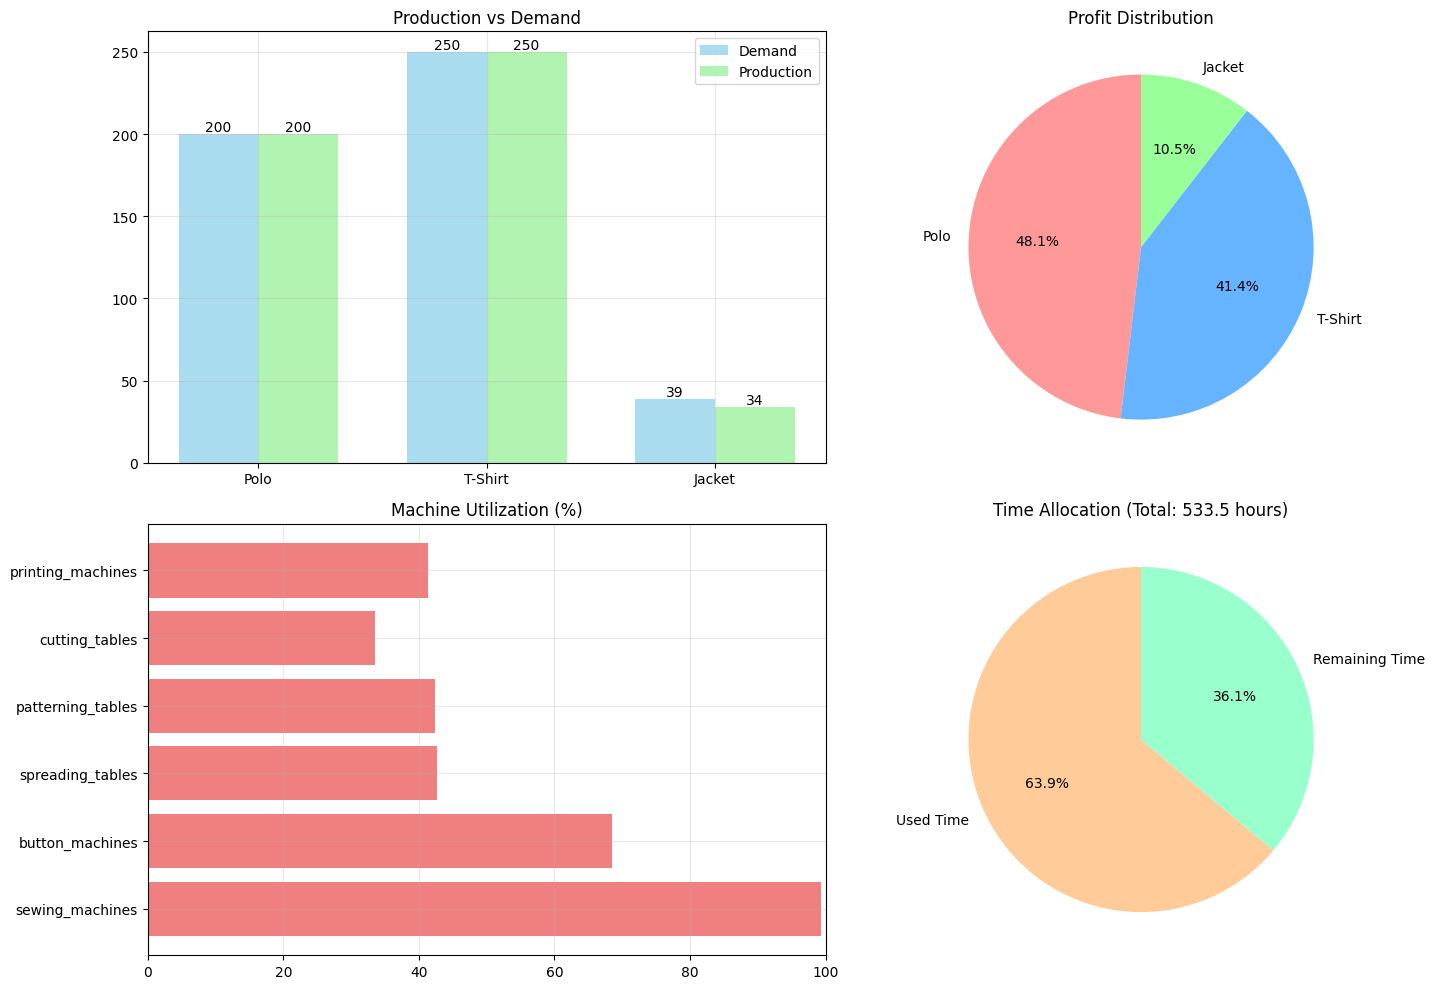

In [10]:
class GarmentFactoryOptimizer:
    """Optimize garment production scheduling and resource allocation"""
    
    def __init__(self, working_days: int = 6, machine_capacity_utilization: float = 0.9, setup_penalty: int = 3000):
        """Initialize factory with production parameters
        
        Args:
            working_days: Number of working days per week (1-7)
            machine_capacity_utilization: Target machine utilization (0-1)
            setup_penalty: Cost penalty for setting up production (non-negative)
            
        Raises:
            ValueError: If any parameter is invalid
        """
        # Input validation for factory parameters
        if not 0 <= machine_capacity_utilization <= 1:
            raise ValueError("Machine utilization must be between 0 and 1")
        if working_days <= 0 or working_days > 7:
            raise ValueError("Working days must be between 1 and 7")
        if setup_penalty < 0:
            raise ValueError("Setup penalty cannot be negative")

        # Store factory configuration parameters
        self.working_days = working_days
        self.machine_capacity_utilization = machine_capacity_utilization
        self.setup_penalty = setup_penalty
        
        # Initialize logging system for debugging
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)
        
        # Define work shifts with their productivity factors
        self.schedule = {
            'morning': {'start': 8, 'end': 11.5, 'productivity': 1.0},      # Peak productivity
            'afternoon': {'start': 13, 'end': 17, 'productivity': 0.9},     # Slightly reduced
            'evening': {'start': 19, 'end': 22, 'productivity': 0.8},       # Lower productivity
        }
        
        # Product specifications with costs, times, and requirements
        self.products = {
            'Polo': {
                'price': 169000,           # Selling price in IDR
                'cost': 60000,             # Production cost in IDR
                'prod_time': 42,           # Production time in minutes
                'setup_time': 15,          # Setup time in minutes
                'additional_processes': {   # Time for each process step
                    'spreading': 10,
                    'patterning': 5,
                    'cutting': 8,
                    'printing': 15
                },
                'demand': 200,             # Weekly demand
                'tools': {                 # Machine requirements per unit
                    'sewing': 1,
                    'button': 0.25,
                    'spreading': 0.5,
                    'patterning': 0.5,
                    'cutting': 0.5,
                    'printing': 0.5
                }
            },
            'T-Shirt': {
                'price': 120000,
                'cost': 45000,
                'prod_time': 28,
                'setup_time': 10,
                'additional_processes': {
                    'spreading': 8,
                    'patterning': 4,
                    'cutting': 6,
                    'printing': 12
                },
                'demand': 250,
                'tools': {
                    'sewing': 1,
                    'spreading': 0.5,
                    'patterning': 0.5,
                    'cutting': 0.5,
                    'printing': 0.5
                }
            },
            'Jacket': {
                'price': 210000,
                'cost': 70000,
                'prod_time': 120,
                'setup_time': 30,
                'additional_processes': {
                    'spreading': 15,
                    'patterning': 8,
                    'cutting': 12,
                    'printing': 20
                },
                'demand': 39,
                'tools': {
                    'sewing': 2,
                    'button': 0.5,
                    'spreading': 1,
                    'patterning': 1,
                    'cutting': 1,
                    'printing': 1
                }
            }
        }
        
        # Validate product data consistency
        self._validate_product_data()
        
        # Calculate profit metrics for each product
        for name, product in self.products.items():
            product['profit_per_unit'] = product['price'] - product['cost']           # Gross profit
            product['profit_per_minute'] = product['profit_per_unit'] / product['prod_time']  # Efficiency metric
        
        # Available factory resources (machines and workers)
        self.resources = {
            'workers': 10,              # Total workforce
            'sewing_machines': 8,       # Main production machines
            'button_machines': 2,       # For button attachment
            'spreading_tables': 2,      # For fabric spreading
            'patterning_tables': 1,     # For pattern making
            'cutting_tables': 2,        # For fabric cutting
            'printing_machines': 3      # For printing designs
        }
        
        # Weekly maintenance time requirements per machine
        self.maintenance = {
            'sewing_machines': 20,      # Minutes per machine per week
            'button_machines': 10,
            'spreading_tables': 25,
            'patterning_tables': 15,
            'cutting_tables': 30,
            'printing_machines': 20
        }
        
        # Pre-calculate important values for optimization
        self.minutes_per_day = self._calculate_minutes_per_day()
        self.machine_capacities = self._calculate_machine_capacities()

    def _validate_product_data(self):
        """Validate consistency between product processes and tool requirements"""
        for product_name, product in self.products.items():
            # Check if all additional processes have corresponding tools
            for process in product['additional_processes']:
                if process not in product['tools']:
                    raise ValueError(
                        f"Process {process} in additional_processes but not in tools for {product_name}"
                    )
            
            # Check if all tools have corresponding time definitions
            for tool in product['tools']:
                if tool in ['sewing', 'button']:
                    # These use main production time
                    if 'prod_time' not in product:
                        raise ValueError(f"Missing prod_time for {product_name}")
                else:
                    # These need specific process times
                    if tool not in product['additional_processes']:
                        raise ValueError(
                            f"Missing time in additional_processes for {tool} in {product_name}"
                        )

    def _calculate_minutes_per_day(self) -> float:
        """Calculate total productive minutes per working day considering shift productivity"""
        return sum(
            (shift['end'] - shift['start']) * 60 * shift['productivity'] 
            for shift in self.schedule.values()
        )

    def _calculate_machine_capacities(self) -> Dict[str, float]:
        """Calculate available machine capacity after maintenance and utilization factors"""
        return {
            resource: (
                # Base capacity: minutes per day * working days * number of machines
                self.minutes_per_day * self.working_days * quantity -
                # Subtract maintenance time
                self.maintenance.get(resource, 0) * quantity * self.working_days
            ) * self.machine_capacity_utilization  # Apply utilization factor
            for resource, quantity in self.resources.items() 
            if resource != 'workers'  # Workers are handled separately
        }

    def optimize_production(self) -> Tuple[Dict[str, int], Dict[str, int], float, float, Dict[str, int], Dict[str, float], float]:
        """Optimize production using two-stage approach: demand fulfillment + profit maximization"""
        try:
            # STAGE 1: Demand-focused optimization
            prob = pulp.LpProblem("Garment_Production_Optimization", pulp.LpMaximize)
            
            # Decision variables: production quantities and setup decisions
            x = {name: pulp.LpVariable(name, lowBound=0, cat='Integer') for name in self.products}
            y = {name: pulp.LpVariable(f"setup_{name}", cat='Binary') for name in self.products}
            
            # Calculate total effective labor minutes available
            effective_minutes = (
                self.minutes_per_day * self.working_days * self.resources['workers'] - 
                sum(
                    self.maintenance[r] * self.resources[r] * self.working_days 
                    for r in self.maintenance
                )
            )
            
            # Objective function: maximize profit minus setup costs
            prob += pulp.lpSum(
                (self.products[n]['price'] - self.products[n]['cost']) * x[n] - 
                self.setup_penalty * y[n] 
                for n in self.products
            )
            
            # Map process names to machine resource names
            machine_types = {
                'sewing': 'sewing_machines',
                'button': 'button_machines',
                'spreading': 'spreading_tables',
                'patterning': 'patterning_tables',
                'cutting': 'cutting_tables',
                'printing': 'printing_machines'
            }
            
            # Machine capacity constraints for each process type
            for process, resource in machine_types.items():
                if any(process in p['tools'] for p in self.products.values()):
                    # Calculate total time needed for this machine type
                    total_time = pulp.lpSum(
                        (p['prod_time'] if process in ['sewing','button'] else 
                         p['additional_processes'].get(process, 0)) *
                        p['tools'].get(process, 0) * x[n]
                        for n, p in self.products.items() 
                        if process in p['tools']
                    )
                    # Add setup time for sewing machines
                    if process == 'sewing':
                        total_time += pulp.lpSum(
                            self.products[n]['setup_time'] * y[n] 
                            for n in self.products
                        )
                    # Constraint: total time <= available capacity
                    prob += total_time <= self.machine_capacities[resource]
            
            # Demand and setup constraints
            for name, product in self.products.items():
                # Don't exceed demand
                if product['demand'] > 0:
                    prob += x[name] <= product['demand']
                else:
                    prob += x[name] == 0
                # Can only produce if setup is done
                prob += x[name] <= (product['demand'] if product['demand'] > 0 else 1) * y[name]
            
            # Labor constraint with 5% buffer for inefficiencies
            prob += pulp.lpSum(
                p['prod_time'] * x[n] * 1.05 
                for n, p in self.products.items()
            ) <= effective_minutes
            
            # Solve the optimization problem
            solver = pulp.PULP_CBC_CMD(msg=False)
            prob.solve(solver)
            
            # Check if solution is optimal
            status = pulp.LpStatus[prob.status]
            if status != 'Optimal':
                raise Exception(
                    f"Stage 1 optimization failed with status: {status}. "
                    "Constraints may be too restrictive or infeasible."
                )
            
            # Extract results from Stage 1
            initial_prod = {n: int(x[n].value()) for n in self.products}
            setups = {n: int(y[n].value()) for n in self.products}
            
            # STAGE 2: Profit-prioritized stock allocation for remaining capacity
            additional_prod = {n: 0 for n in self.products}
            
            # Calculate remaining labor capacity
            remaining_labor = effective_minutes - sum(
                p['prod_time'] * initial_prod[n] * 1.05 
                for n, p in self.products.items()
            )
            
            # If all demand is fulfilled and capacity remains, produce additional stock
            if all(
                initial_prod[n] >= p['demand'] 
                for n, p in self.products.items() 
                if p['demand'] > 0
            ) and remaining_labor > 0:
                
                self.logger.info("All demand fulfilled - allocating remaining capacity")
                
                # Calculate remaining machine capacities
                remaining_resources = self._calculate_remaining_resources(initial_prod, setups)
                
                # Sort products by profit per minute (highest first)
                products_sorted = sorted(
                    [(n, p) for n, p in self.products.items() if p['demand'] > 0],
                    key=lambda x: x[1]['profit_per_minute'],
                    reverse=True
                )
                
                # Greedily allocate remaining capacity to most profitable products
                for name, product in products_sorted:
                    while remaining_labor > 0:
                        can_produce, required = self._can_produce_unit(
                            name, 
                            remaining_resources, 
                            remaining_labor
                        )
                        if can_produce:
                            additional_prod[name] += 1
                            remaining_labor -= product['prod_time'] * 1.05
                            # Update remaining resources
                            for resource, amount in required.items():
                                remaining_resources[resource] -= amount
                        else:
                            break
            
            # Combine initial and additional production
            final_prod = {
                n: initial_prod[n] + additional_prod[n]
                for n in self.products
            }
            
            # Calculate final remaining resources
            remaining_resources = self._calculate_remaining_resources(final_prod, setups)
            
            return (
                final_prod,                     # Final production quantities
                setups,                         # Setup decisions
                effective_minutes,              # Total available minutes
                remaining_labor / 60,           # Remaining hours
                additional_prod,                # Additional production beyond demand
                remaining_resources,            # Remaining machine capacities
                effective_minutes - remaining_labor  # Used labor minutes
            )
            
        except Exception as e:
            self.logger.error(f"Optimization failed: {str(e)}", exc_info=True)
            raise

    def _calculate_remaining_resources(self, production, setups) -> Dict[str, float]:
        """Calculate remaining machine capacity after production allocation"""
        remaining = self.machine_capacities.copy()
        
        # Map process names to machine resource names
        machine_types = {
            'sewing': 'sewing_machines',
            'button': 'button_machines',
            'spreading': 'spreading_tables',
            'patterning': 'patterning_tables',
            'cutting': 'cutting_tables',
            'printing': 'printing_machines'
        }
        
        # Subtract time used by each product for each process
        for name, product in self.products.items():
            for process in product['tools']:
                resource = machine_types[process]
                # Calculate time per unit for this process
                time_per_unit = (
                    product['prod_time'] if process in ['sewing','button'] else
                    product['additional_processes'].get(process, 0)
                ) * product['tools'][process]
                # Subtract total time used
                remaining[resource] -= time_per_unit * production[name]
        
        # Subtract setup time for sewing machines
        if 'sewing_machines' in remaining:
            remaining['sewing_machines'] -= sum(
                self.products[n]['setup_time'] * setups[n] 
                for n in self.products
            )
        
        # Ensure no negative values
        return {k: max(0, v) for k, v in remaining.items()}

    def _can_produce_unit(self, product_name, remaining_resources, remaining_labor):
        """Check if one additional unit can be produced given current constraints"""
        product = self.products[product_name]
        required_resources = {}
        
        # Check labor constraint first
        labor_needed = product['prod_time'] * 1.05
        if remaining_labor < labor_needed:
            return False, {}
        
        # Map process names to machine resource names
        machine_types = {
            'sewing': 'sewing_machines',
            'button': 'button_machines',
            'spreading': 'spreading_tables',
            'patterning': 'patterning_tables',
            'cutting': 'cutting_tables',
            'printing': 'printing_machines'
        }
        
        # Check each machine constraint
        for process in product['tools']:
            resource = machine_types[process]
            # Calculate time needed for this process
            time_needed = (
                product['prod_time'] if process in ['sewing','button'] else
                product['additional_processes'].get(process, 0)
            ) * product['tools'][process]
            
            # Check if enough capacity remains
            if remaining_resources.get(resource, 0) < time_needed:
                return False, {}
            
            required_resources[resource] = time_needed
        
        return True, required_resources

    def generate_report(self, production, setup, effective_minutes, remaining_hours,
                      additional_production, remaining_capacity, used_labor) -> str:
        """Generate comprehensive production optimization report"""
        report = [
            "\n=== PRODUCTION OPTIMIZATION REPORT ===",
            f"\nFactory Configuration:",
            f"- Working days/week: {self.working_days}",
            f"- Machine utilization: {self.machine_capacity_utilization:.0%}",
            f"- Setup cost: Rp {self.setup_penalty:,}",
            
            f"\nProduction Summary:",
            f"- Total effective time: {effective_minutes/60:.1f} hours",
            f"- Used production time: {used_labor/60:.1f} hours",
            f"- Remaining time: {remaining_hours:.1f} hours",
            f"- Total profit: Rp {sum((self.products[n]['price']-self.products[n]['cost'])*production[n] for n in self.products):,}",
            
            "\nProduct Details:"
        ]
        
        # Generate detailed report for each product
        for name, product in self.products.items():
            # Calculate demand fulfillment rate
            fulfilled = (
                production[name] / product['demand'] 
                if product['demand'] > 0 
                else 1 if production[name] == 0 else float('inf')
            )
            
            # Add information about additional stock production
            additional_info = ""
            if additional_production[name] > 0:
                additional_info = (
                    f"\n  Additional stock: {additional_production[name]} units "
                    f"(priority based on profit per minute)"
                )
            
            report.extend([
                f"\n{name}:",
                f"- Demand: {product['demand']}",
                f"- Produced: {production[name]}",
                f"- Fulfillment: {fulfilled:.1%}{additional_info}",
                f"- Unit profit: Rp {product['price']-product['cost']:,}",
                f"- Total profit: Rp {(product['price']-product['cost'])*production[name]:,}"
            ])
        
        # Add remaining machine capacity information
        report.append("\nRemaining Machine Capacities (minutes):")
        for machine, minutes in remaining_capacity.items():
            report.append(f"- {machine.replace('_', ' ').title()}: {minutes:.1f}")
        
        return "\n".join(report)

    def visualize_results(self, results):
        """Create comprehensive visualization of optimization results with 4 subplots"""
        # Extract all results from the optimization
        production, setup, effective_minutes, remaining_hours, additional_production, remaining_capacity, used_labor = results
        
        # Create figure with 2x2 subplot layout
        plt.figure(figsize=(15, 10))
        
        # Subplot 1: Production vs Demand comparison
        plt.subplot(2, 2, 1)
        products = list(self.products.keys())
        demands = [self.products[p]['demand'] for p in products]
        productions = [production[p] for p in products]
        
        x = np.arange(len(products))
        width = 0.35
        
        # Create bars for demand and production
        bars1 = plt.bar(x - width/2, demands, width, label='Demand', alpha=0.7, color='skyblue')
        bars2 = plt.bar(x + width/2, productions, width, label='Production', alpha=0.7, color='lightgreen')
        
        # Add additional production on top of regular production
        for i, add in enumerate(additional_production.values()):
            if add > 0:
                plt.bar(x[i] + width/2, add, width, bottom=productions[i]-add, 
                       color='gold', alpha=0.6, label='Additional' if i==0 else "")
        
        # Add value labels on bars
        for bar in bars1 + bars2:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom')
        
        plt.xticks(x, products)
        plt.title('Production vs Demand')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Subplot 2: Profit distribution pie chart
        plt.subplot(2, 2, 2)
        profits = [(self.products[p]['price'] - self.products[p]['cost']) * production[p] 
                  for p in products]
        plt.pie(profits, labels=products, autopct='%1.1f%%', startangle=90,
                colors=['#ff9999','#66b3ff','#99ff99'])
        plt.title('Profit Distribution')
        
        # Subplot 3: Machine utilization bar chart
        plt.subplot(2, 2, 3)
        machines = list(remaining_capacity.keys())
        # Calculate utilization percentage for each machine
        utilization = [(self.machine_capacities[m] - remaining_capacity[m]) / self.machine_capacities[m] * 100 
                      for m in machines]
        plt.barh(machines, utilization, color='lightcoral')
        plt.title('Machine Utilization (%)')
        plt.xlim(0, 100)
        plt.grid(True, alpha=0.3)
        
        # Subplot 4: Time allocation pie chart
        plt.subplot(2, 2, 4)
        time_used = [used_labor/60, remaining_hours]
        plt.pie(time_used, labels=['Used Time', 'Remaining Time'], 
                autopct='%1.1f%%', startangle=90, colors=['#ffcc99','#99ffcc'])
        plt.title(f'Time Allocation (Total: {effective_minutes/60:.1f} hours)')
        
        # Adjust layout to prevent overlap
        plt.tight_layout()
        plt.show()


# Main execution block
if __name__ == "__main__":
    try:
        # Initialize factory with specific parameters
        factory = GarmentFactoryOptimizer(
            working_days=6,                    # 6 working days per week
            machine_capacity_utilization=0.9,  # 90% machine utilization target
            setup_penalty=3000                 # Setup cost of 3000 IDR
        )
        
        # Run the optimization process
        results = factory.optimize_production()
        
        # Generate and display the report
        report = factory.generate_report(*results)
        print(report)
        
        # Create visual charts of the results
        factory.visualize_results(results)
        
    except Exception as e:
        print(f"Error: {str(e)}")

# **RESULT**

## 📊 Production Optimization Report Summary

---

### 🗓️ Week 1 Results (Baseline)

| Metric                     | Value                |
|----------------------------|----------------------|
| Total Profit               | Rp 37,825,000       |
| Effective Time Utilization | 309.8/533.5 hours   |
| Remaining Capacity         | 223.7 hours         |

| Product  | Produced | Demand | Fulfillment | Additional Stock | Profit Contribution |
|----------|----------|--------|-------------|------------------|---------------------|
| Polo     | 150      | 150    | 100%        | -                | Rp 16,350,000       |
| T-Shirt  | 193      | 150    | 128.7%      | 43 units         | Rp 14,475,000       |
| Jacket   | 50       | 50     | 100%        | -                | Rp 7,000,000        |

| Machine Type       | Remaining Minutes |
|--------------------|-------------------|
| Sewing Machines    | 1.0 (Bottleneck)  |
| Button Machines    | 1,473.0           |
| Printing Machines  | 5,627.0           |

✅ **Key Insights (Week 1)**:
- Objective achieved: profit maximized with prioritized allocation to T-Shirts (highest profit per minute).
- Random processing issue resolved with ILP-based prioritization.
- Sewing machines identified as a bottleneck with only 1 minute left, highlighting the need to expand capacity.
- Total profit reached Rp 37,825,000.

---

### 🗓️ Week 2 Results (Updated Demand)

| Metric                     | Value                |
|----------------------------|----------------------|
| Total Profit               | Rp 45,310,000       |
| Effective Time Utilization | 340.9/533.5 hours   |
| Remaining Capacity         | 192.6 hours         |

| Product  | Produced | Demand | Fulfillment | Additional Stock | Profit Contribution |
|----------|----------|--------|-------------|------------------|---------------------|
| Polo     | 200      | 200    | 100%        | -                | Rp 21,800,000       |
| T-Shirt  | 250      | 250    | 100%        | -                | Rp 18,750,000       |
| Jacket   | 34       | 39     | 87.2%       | 5 units short    | Rp 4,760,000        |

| Machine Type       | Remaining Minutes |
|--------------------|-------------------|
| Sewing Machines    | 145.0             |
| Button Machines    | 1,908.0           |
| Printing Machines  | 5,230.0           |

✅ **Key Insights (Week 2)**:
- Demand increased: Polo (+50 units) and T-Shirt (+100 units) fulfilled at 100%, while Jacket fulfillment dropped to 87.2% (5 units short).
- Profit increased by 19.8% compared to Week 1, reaching Rp 45,310,000.
- Sewing machine capacity improved with 145 minutes remaining — a significant recovery from Week 1’s critical bottleneck.
- ILP model effectively adapted production priorities to meet new demand while maximizing profit.

---

### 🛠️ Overall Recommendations
- Continue monitoring sewing capacity closely as it remains a critical constraint for meeting future demand increases.
- Investigate the cause of decreased Jacket fulfillment; reassess whether priority should shift or additional resources are needed.
- Maintain weekly demand updates into the ILP model to ensure continued profit maximization and balanced stock levels.